<a href="https://colab.research.google.com/github/cse-teacher/suggestion-mining/blob/main/suggestion_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suggestion Mining
Suggestion mining is the task of extracting suggestions from user reviews

Developed: 11 Feb 2024 \\
Last Update: 11 Feb 2024 \\
Author: Muharram Mansoorizadeh plus Various AI tools (Google search, chatGPT, Gemini , ...)




## Install Required Packagaes

In [ ]:
#Install required packages and libraries

!apt-get install libenchant-2-2
!pip install emoji
!pip install cleantext
!pip install nltk
!pip install pyenchant
!pip install scikit-learn lightgbm catboost
!pip install gensim
!pip install transformers sentencepiece sacremoses
!pip install ekphrasis

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip3 install spacy

!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 409.6 kB/s eta 0:00:32
     --------------------------------------- 0.1/12.8 MB 598.8 kB/s eta 0:00:22
     --------------------------------------- 0.1/12.8 MB 516.7 kB/s eta 0:00:25
      -------------------------------------- 0.3/12.8 MB 874.6 kB/s eta 0:00:15
     - ------------------------------------- 0.3/12.8 MB 955.3 kB/s eta 0:00:14
     - -------------------------------------- 0.5/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.7/12.8 MB 1.5 MB/s eta 0:00:08
     --- ------------------------------------ 1.1/12.8 MB 2.1 MB/s eta 0:00:06
     ---- ----------------------------------- 1.5/12.8 MB 2.5 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
ner_categories =['PERSON', 'PRDOUCT' , 'ORG', 'GPE']
text = 'John drives to Sidny school every day with his windows phone made by microsoft'
doc = nlp(text)
print(doc)
for ent in doc.ents:
  print(ent.text , ent.label, ent.label_)

John drives to Sidny school every day with his windows phone made by microsoft
John 380 PERSON
Sidny 384 GPE
microsoft 383 ORG


## Import data

Get the required data files from github repository

In [ ]:
!git clone https://github.com/cse-teacher/suggestion-mining.git

fatal: destination path 'suggestion-mining' already exists and is not an empty directory.


## Prepare data

In [ ]:
# Read data from input files
#Reset environment
%reset -f

import numpy as np
import pandas as pd
import random
import sys
from datetime import datetime

#Set default seed:
random.seed(42)

#Main Application
folder     = "./suggestion-mining/data/"
train_file = folder + "V1.4_Training.csv" #"Train_Augmented_03.csv" # V1.4_Training.csv" #  "Train_processed.csv" /suggestion-mining/data/Train_Augmented_03.csv
valid_file = folder + "SubtaskA_Trial_Test_Labeled.csv" #"validation_processed.csv"
test_file  = folder + "SubtaskA_EvaluationData_labeled.csv"

train_df = pd.read_csv(train_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

valid_df = pd.read_csv(valid_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

test_df  = pd.read_csv(test_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

all_df = pd.concat([train_df, valid_df, test_df], axis=0)


#Get the labels:
y_train_original = train_df['label'].values
y_valid_original = valid_df['label'].values
y_test_original  = test_df['label'].values
y_all_original  = all_df['label'].values
train_size = len(train_df['label'])
valid_size = len(valid_df['label'])
test_size  = len(test_df['label'])

# to save results and models we need time-based file names
current_datetime = datetime.now()
results_df = pd.DataFrame({'labels': y_test_original})
start_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print(f"current start time {start_time_str}")

current start time 2024-04-10_16-11-43


**Preprocessing**

In [ ]:
import sys
import re
import nltk
import cleantext
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def remove_nonalpha(text):
    #text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

def remove_nonalphanumeric(text):
    #text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text = re.sub(r'\W+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

def remove_stopwords_list(tokens):
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

def remove_stopwords(text):
  tokens = word_tokenize(text)
  filtered_tokens = remove_stopwords_list(tokens)
  return ' '.join(filtered_tokens)

#-----------------------------------
# Replace hyperlinks
#
def replace_hyperlinks(text):
  text = re.sub(r'https?:\/\/\S+', 'hyperlink', text)
  return text

def stem(text):
  tokens = word_tokenize(text.strip())
  tokens_stem =[stemmer.stem(s) for s in tokens]
  return ' '.join(tokens_stem)

#----------------------------------------
# replace_named_entities:
#    Replaces each word or phrase in the input text with its
#    Named Entity Recognition (NER) tag label.
#    Args:
#    text (str): Input text
#
#    Returns:
#    str: Text with named entities replaced by their NER tag labels
#
def replace_named_entities(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Tag the words with Part-of-Speech (POS) tags
    tagged_words = pos_tag(words)

    # Perform Named Entity Recognition (NER)
    named_entities = ne_chunk(tagged_words)

    # Replace entities with their NER tag labels
    replaced_text = []
    for entity in named_entities:
        if isinstance(entity, nltk.tree.Tree):
            label = entity.label()
            named_entity_text = " ".join([word for word, tag in entity.leaves()])
            #replaced_text.append(f'<{label}>{named_entity_text}</{label}>')
            replaced_text.append(f'{label}')
            #replaced_text.append('')
        else:
            replaced_text.append(entity[0])

    return " ".join(replaced_text)

#Global callings:
stemmer = SnowballStemmer("english")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Example usage:
text = "Microsoft should seriously look into getting rid of Syamentc for all these paying stuff"
replaced_text = replace_named_entities(text)
print("Replaced Text:", replaced_text)


Replaced Text: PERSON should seriously look into getting rid of GPE for all these paying stuff


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
op_replace_hyperlinks      = True
op_remove_nonalphanumeric  = True
op_remove_nonalpha         = True
op_remove_stopwords        = False
op_replace_named_entities  = False
op_stem                    = False

if op_replace_hyperlinks == True:
  #replace named entities with their tag names:
  train_df['sentence']  = train_df['sentence'].apply(replace_hyperlinks)
  test_df['sentence']   = test_df['sentence'].apply(replace_hyperlinks)
  valid_df['sentence']  = valid_df['sentence'].apply(replace_hyperlinks)
  all_df['sentence']    = all_df['sentence'].apply(replace_hyperlinks)

if op_remove_nonalphanumeric == True:
  train_df['sentence'] = train_df['sentence'].apply(remove_nonalphanumeric)
  valid_df['sentence'] = valid_df['sentence'].apply(remove_nonalphanumeric)
  test_df['sentence']  = test_df['sentence'].apply(remove_nonalphanumeric)
  all_df['sentence']   = all_df['sentence'].apply(remove_nonalphanumeric)

if op_remove_nonalpha  == True:
  train_df['sentence'] = train_df['sentence'].apply(remove_nonalpha)
  valid_df['sentence'] = valid_df['sentence'].apply(remove_nonalpha)
  test_df['sentence']  = test_df['sentence'].apply(remove_nonalpha)
  all_df['sentence']   = all_df['sentence'].apply(remove_nonalpha)


if op_replace_named_entities == True:
  train_df['sentence']  = train_df['sentence'].apply(replace_named_entities)
  test_df['sentence']   = test_df['sentence'].apply(replace_named_entities)
  valid_df['sentence']  = valid_df['sentence'].apply(replace_named_entities)
  all_df['sentence']    = all_df['sentence'].apply(replace_named_entities)

if op_remove_stopwords == True:
  train_df['sentence'] = train_df['sentence'].apply(remove_stopwords)
  valid_df['sentence'] = valid_df['sentence'].apply(remove_stopwords)
  test_df['sentence']  = test_df['sentence'].apply(remove_stopwords)
  all_df['sentence']   = all_df['sentence'].apply(remove_stopwords)

if op_stem == True:
  train_df['sentence'] = train_df['sentence'].apply(stem)
  valid_df['sentence'] = valid_df['sentence'].apply(stem)
  test_df['sentence']  = test_df['sentence'].apply(stem)
  all_df['sentence']   = all_df['sentence'].apply(stem)

#print some instances
train_df['sentence'][195:200].tolist()


[' When creating an app that uses MediaStreamSource to stream audio in Windows Phone everything works just great ',
 ' When porting this app to Windows Phone the sound is flickering and its components are stack overflow ing ',
 ' Here is a discussion on MSDN forums hyperlink And here is a sample project source code hyperlink',
 ' we are publishing the same apps in Windows Phone Store and Windows App Store ',
 ' Now we want to bundle these Apps ']

## Feature extraction

In [ ]:
#Extract BOW feature test
import nltk
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import wordpunct_tokenize
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#----------------------
# BOW Features
bow_vectorizer = CountVectorizer(analyzer='word',
                                 stop_words=None,
                                 lowercase=True,
                                 encoding='utf-8',
                                 min_df = 3 ,
                                 max_df = 0.975,
                                 ngram_range =(1,5))

bow_vectorizer.fit(all_df['sentence'])
train_bow_features = bow_vectorizer.transform(train_df['sentence']).toarray()
valid_bow_features = bow_vectorizer.transform(valid_df['sentence']).toarray()
test_bow_features  = bow_vectorizer.transform(test_df['sentence']).toarray()
all_bow_features   = bow_vectorizer.transform(all_df['sentence']).toarray()

#----------------------
# TF-IDF Features

# Fit the vectorizer on the sentences to learn vocabulary and IDF weights
tfidf_vectorizer = TfidfVectorizer(stop_words=None,
                                 lowercase=True,
                                 encoding='utf-8',
                                 min_df = 3 ,
                                 max_df = 0.975, #
                                 ngram_range =(1,5))

tfidf_vectorizer.fit(all_df['sentence'])

# Transform the sentences into tf-idf vectors
train_tfidf_features = tfidf_vectorizer.transform(train_df['sentence']).toarray()
test_tfidf_features  = tfidf_vectorizer.transform(test_df['sentence']).toarray()
valid_tfidf_features = tfidf_vectorizer.transform(valid_df['sentence']).toarray()
all_tfidf_features   = tfidf_vectorizer.transform(all_df['sentence']).toarray()

#------------------------------------------------
# word2vec features
#
docs = [wordpunct_tokenize(doc) for doc in all_df['sentence']]
docs1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
model_d2v = Doc2Vec(docs1, vector_size=300, window=4, min_count=1, workers=4, epochs=100)

#Get the features:
vectors = [model_d2v.infer_vector(doc) for doc in(docs)]
all_d2v_features = np.array(vectors)
train_d2v_features = all_d2v_features[0:train_size,:]
valid_d2v_features = all_d2v_features[train_size:train_size+valid_size,:]
test_d2v_features  = all_d2v_features[train_size+valid_size:,:]

#define global features, empty at first:
X_train     = np.empty([])
X_test      = np.empty([])
X_valid     = np.empty([])
X_all       = np.empty([])
X_train_val = np.empty([])

y_train = y_train_original
y_valid = y_valid_original
y_test  = y_test_original
y_all   = y_all_original
y_train_val = np.concatenate((y_train , y_valid), axis= 0 )
print(f"Features size: \nBow: {all_bow_features.shape},\nBOW: { all_tfidf_features.shape}\nDoc2vec: {all_d2v_features.shape}")

Features size: 
Bow: (9925, 21609),
BOW: (9925, 21609)
Doc2vec: (9925, 300)


In [ ]:
#===============================================
# Utility functions
#

import tensorflow as tf
import string
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import csv
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier


#------------------------------------------------
# apply the given option
#
def select_optional_features(feature_group,
                 op_scale_features  = False,
                 op_upsample_smote  = False,
                 op_upsample_over   = False,
                 op_transform_pca   = False,
                 op_downsample_majority = False
                 ):
  global X_train, X_valid, X_test, X_all
  global y_train, y_valid, y_test, y_all
  global X_train_val , y_train_val
  global results_df, start_time_str

  description = feature_group
  y_train = y_train_original
  y_valid = y_valid_original
  y_test  = y_test_original

  if feature_group == 'tfidf' :
    X_train = train_tfidf_features
    X_test  = test_tfidf_features
    X_valid = valid_tfidf_features
    X_all   = all_tfidf_features
  elif feature_group == 'bow':
    X_train = train_bow_features
    X_test  = test_bow_features
    X_valid = valid_bow_features
    X_all   = all_bow_features
  elif feature_group == 'd2v':
    X_train = train_d2v_features
    X_test  = test_d2v_features
    X_valid = valid_d2v_features
    X_all   = all_d2v_features

  if op_scale_features == True: # Scale numerical features
     scaler  = StandardScaler().fit(X_all); description += ', Standard Scaler'
     X_all   = scaler.transform(X_all)
     X_train = scaler.transform(X_train)
     X_test  = scaler.transform(X_test)
     X_valid = scaler.transform(X_valid)

  if op_upsample_smote == True: # SMOTE oversampling
    smote = SMOTE(sampling_strategy="minority") ; description += ', SMOTE Augmentation'
    X_train, y_train = smote.fit_resample(X_train, y_train)

  if op_upsample_over == True: # Random oversampling
    oversampler = RandomOverSampler(random_state=42); description += ', oversampling Augmentation'
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

  if op_transform_pca == True:  # Do PCA
    #n_comps = min(500 , 0.1 * X_all.shape[1])
    pca = PCA(n_components=0.95).fit(X_all);  description += ', PCA'
    X_train = pca.transform(X_train) ; X_test = pca.transform(X_test)
    X_valid = pca.transform(X_valid) ; X_all = pca.transform(X_all)

  if op_downsample_majority == True:  # Down sample majority class
      # Separate instances for class 1
    class_1_instances = X_train[y_train == 1,:]
    class_0_instances = X_train[y_train == 0,:]
    number_of_samples = class_1_instances.shape[0]
    indices = np.random.choice(class_0_instances.shape[0], number_of_samples, replace=False)
    sampled_class_0_instances = class_0_instances[indices,:]

    # Combine instances for class 1 and sampled instances from class 0
    X_train = np.concatenate([class_1_instances, sampled_class_0_instances])
    y_train = np.concatenate([np.ones(class_1_instances.shape[0]), np.zeros(sampled_class_0_instances.shape[0])])


    # Train + Validation data
  X_train_val = np.concatenate((X_train, X_valid) , axis=0)
  y_train_val = np.concatenate((y_train, y_valid) , axis=0)
  return description

#----------------------------------
# Print results per class
#
def print_per_class_results(y_actual, y_pred, description=''):
  for label in (0,1):
    v0 = accuracy_score(y_actual, y_pred)
    v1 = precision_score(y_actual, y_pred, pos_label=label)
    v2 = recall_score(y_actual, y_pred, pos_label=label)
    v3 = f1_score(y_actual, y_pred, pos_label=label)
    print(f"{description},\t class={label}\tAccuracy={v0:.2f},\t Precision={v1:.2f},\tRecall={v2:.2f}\tF1-score={v3:.2f}")


#----------------------------------
# Print results per class
#
def print_results(y_actual, y_pred, description=''):

  try:
    v00 = accuracy_score(y_actual, y_pred)
    v01 = precision_score(y_actual, y_pred, pos_label=0)
    v02 = recall_score(y_actual, y_pred, pos_label=0)
    v03 = f1_score(y_actual, y_pred, pos_label=0)

    v11 = precision_score(y_actual, y_pred, pos_label=1)
    v12 = recall_score(y_actual, y_pred, pos_label=1)
    v13 = f1_score(y_actual, y_pred, pos_label=1)

    smsg = f"{description},\tAccuracy={v00:.2f},\tC0: Pr={v01:.2f}, Re={v02:.2f}, F1={v03:.2f},\tC1: Pr={v11:.2f}, Re={v12:.2f}, F1={v13:.2f}"
    print(smsg)
    with open(f"results_{start_time_str}.txt", "a") as myfile:
      myfile.write(f"{datetime.now()}\t {smsg}\n")

    results_df.insert(len(results_df.columns),description, y_pred)
  except Exception as error:
      print(f"something went wrong {error}")

#cutoff probability to make a binary value
def prob2label (y, threshold=0.5):
  y[y <  threshold] = 0
  y[y >= threshold] = 1
  return y


In [ ]:
#ttest based keywords selection:
# Import the library
import scipy.stats as stats

def ttest2(X,y):
  X1 = X[y==1, :]; X2 =X[y!=1,:] ;
  numcols = X.shape[1]
  sval = np.zeros(numcols, float)
  pval = np.zeros(numcols, float)
  for k in range(0,numcols):
    test_result = stats.ttest_ind(a=X1[:,k], b=X2[:,k], equal_var=True)
    sval[k] = test_result.statistic
    pval[k] = test_result.pvalue
  return sval, pval

# filter bow features
cutoff = 0.1
[A,B] = ttest2(train_bow_features , y_train)
best_bow_features = np.argsort(B, axis=-1, kind=None, order=None)
last_bow_feature = np.min(np.argwhere(B[best_bow_features] >= cutoff))
best_bow_feature_names = bow_vectorizer.get_feature_names_out()[best_bow_features[0:last_bow_feature]]

print("top bag of words features")
for temp1, temp2 in zip(A[best_bow_features[0:21]] , best_bow_feature_names[0:21]):
  print(temp1, temp2)

train_bow_features= train_bow_features[:,best_bow_features[0:last_bow_feature]]
test_bow_features = test_bow_features[:,best_bow_features[0:last_bow_feature]]
valid_bow_features = valid_bow_features[:,best_bow_features[0:last_bow_feature]]
all_bow_features   = all_bow_features[:,best_bow_features[0:last_bow_feature]]

# filter tfidf features
[A,B] = ttest2(train_tfidf_features , y_train)
best_tfidf_features = np.argsort(B, axis=-1, kind=None, order=None)
last_tfidf_feature  = np.min(np.argwhere(B[best_tfidf_features] > cutoff))
best_tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()[best_tfidf_features[0:last_tfidf_feature]]

train_tfidf_features= train_tfidf_features[:,best_tfidf_features[0:last_tfidf_feature]]
test_tfidf_features = test_tfidf_features[:,best_tfidf_features[0:last_tfidf_feature]]
valid_tfidf_features = valid_tfidf_features[:,best_tfidf_features[0:last_tfidf_feature]]
all_tfidf_features   = all_tfidf_features[:,best_tfidf_features[0:last_tfidf_feature]]

print("top tfidf features")
for temp1, temp2 in zip(A[best_tfidf_features[0:21]] , best_tfidf_feature_names[0:21]):
  print(temp1, temp2)

top bag of words features
29.84823731094551 be
26.83771370728371 please
24.477182481135024 would
24.277129097207578 should
24.04109159453123 would be
23.744243274558357 it would be
23.028961778924728 it would
19.647209708601522 add
17.91422174105728 should be
16.341188180608427 to
15.684943328100735 be nice
15.107936555960004 allow
14.829530810372402 would be nice
14.561731461492071 be great
14.261383265436097 would like
14.213066453660174 like
13.949114539147656 could
13.878409913159958 like to
13.60842887725592 nice
13.225095456619743 please add
13.151128026483732 would be great
top tfidf features
26.860273305594365 be
23.341397329294534 should
22.972202109103893 it would be
22.599648508804396 please
21.663924479147987 it would
20.85548177338402 would be
20.704967010442438 would
19.145279434238937 add
17.074184741542684 should be
16.188344780708565 to
14.949655022078138 allow
14.896112496339999 be nice
14.126907397595398 would be nice
13.851169888779989 would like
-13.49532185795253 

In [ ]:
import os

# print output to the console
print(os.getcwd())
#os.chdir('c:/users/mmr')
print(os.getcwd())


C:\Users\mmr
C:\Users\mmr


In [ ]:
print(f"Top 10 bow features{best_bow_feature_names[0:10]}")
print(f"Top 10 tfidf features{best_tfidf_feature_names[0:10]}")
#results_df.to_csv(f"labels_{start_time_str}.csv")

Top 10 bow features['be' 'please' 'would' 'should' 'would be' 'it would be' 'it would' 'add'
 'should be' 'to']
Top 10 tfidf features['be' 'should' 'it would be' 'please' 'it would' 'would be' 'would' 'add'
 'should be' 'to']


# Experiments



## Utility Functions


**Experimental Setup**

In [ ]:
 #select options here and run classifiers as you like:

 current_options = select_optional_features(feature_group = 'tfidf',
                 op_scale_features  = False,
                 op_upsample_smote  = False,
                 op_upsample_over   = False,
                 op_transform_pca   = False ,
                 op_downsample_majority = False,

                                            )

 print(current_options)

tfidf


##Rule Based Methods##

This section contains several rule based methods.

In [ ]:
keyword_group = 'human'
keyword_count = 20
human_keywords = ["should", "could", "might", "ought to", "would", "recommend",
                       "suggest", "consider", "better", "allow", "would you mind",
                       "could you please", "I suggest", "please", "if you want to",
                       "be able to", "it would be"]

if keyword_group =='human':
  suggestion_keywords = human_keywords

elif keyword_group =='bow':
  suggestion_keywords = best_bow_feature_names.tolist()

elif keyword_group == 'tfidf':
  suggestion_keywords = best_tfidf_feature_names.tolist()

if keyword_count >0 :
  suggestion_keywords = suggestion_keywords[0:min(keyword_count, len(suggestion_keywords))]

def contains_suggestion(paragraph):
    for keyword in suggestion_keywords:
        if keyword in paragraph.lower():
            return True
    return False

def classify_paragraphs(paragraphs):
    y_pred = []
    for paragraph in paragraphs:
        if contains_suggestion(paragraph):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred


y_pred = classify_paragraphs(test_df['sentence'])
print_results(y_test, y_pred, f"keywords: {keyword_group}, count: {len(suggestion_keywords)}" )

keywords: human, count: 17,	Accuracy=0.87,	C0: Pr=0.97, Re=0.89, F1=0.93,	C1: Pr=0.44, Re=0.76, F1=0.56


**Basic Methods**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# Create MinMaxScaler instance with feature_range=(0, 10)
scaler = MinMaxScaler(feature_range=(10, 20))

# Fit the scaler to your data
scaler.fit(X_all)

# Transform your data
X1 = scaler.transform(X_train_val)
X2 = scaler.transform(X_test)

# Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X1, y_train_val)
nb_predictions = nb_classifier.predict(X2)

# Bayesian classifier
bayesian_classifier = BayesianRidge()
bayesian_classifier.fit(X1, y_train_val)
bayesian_predictions = bayesian_classifier.predict(X2)


# Evaluation
print_results(y_test , nb_predictions >=0.5, 'Naive Bayes, '+ current_options)
print_results(y_test , bayesian_predictions>=0.5, 'BayesianRidge, '+ current_options)



Naive Bayes, tfidf,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.95,	C1: Pr=0.57, Re=0.05, F1=0.09
BayesianRidge, tfidf,	Accuracy=0.91,	C0: Pr=0.95, Re=0.94, F1=0.95,	C1: Pr=0.54, Re=0.57, F1=0.56


In [ ]:
#Some Useful classifiers
def test_basic_models(X1,y1,X2,y2, description):
  classifiers = {
      'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=21, metric="cosine"),
      'Linear Discrimination Analysis':LinearDiscriminantAnalysis(),
      'Logistic Regression': sklearn.linear_model.LogisticRegression(random_state=42),
      'Support Vector Machine-L': sklearn.svm.SVC(kernel='linear', random_state=42),
      'Support Vector Machine-R': sklearn.svm.SVC(kernel='rbf', random_state=42),
      'Support Vector Machine-S': sklearn.svm.SVC(kernel='sigmoid', random_state=42),
      'Support Vector Machine-WL': sklearn.svm.SVC(kernel="linear", class_weight={1: 10}, random_state=42),
      'Support Vector Machine-WR': sklearn.svm.SVC(kernel="rbf", class_weight={1: 10}, random_state=42),
      'Support Vector Machine-WS': sklearn.svm.SVC(kernel="sigmoid", class_weight={1: 10}, random_state=42),
      'Decision Tree classifier': DecisionTreeClassifier(max_depth=15, random_state=42),
  }

  # Loop through each classifier and evaluate performance
  for name, clf in classifiers.items():
      clf.fit(X1, y1)
      y_pred = clf.predict(X2)
      print_results(y2 , y_pred, 'basic ' + name + ', '+ description)
#---------------------
test_basic_models (X_train_val , y_train_val , X_test , y_test, current_options)


basic K-Nearest Neighbors, tfidf,	Accuracy=0.91,	C0: Pr=0.92, Re=0.98, F1=0.95,	C1: Pr=0.67, Re=0.28, F1=0.39
something went wrong cannot insert basic K-Nearest Neighbors, tfidf, already exists
basic Linear Discrimination Analysis, tfidf,	Accuracy=0.80,	C0: Pr=0.95, Re=0.83, F1=0.88,	C1: Pr=0.29, Re=0.60, F1=0.39
basic Logistic Regression, tfidf,	Accuracy=0.92,	C0: Pr=0.94, Re=0.98, F1=0.96,	C1: Pr=0.67, Re=0.43, F1=0.52
basic Support Vector Machine-L, tfidf,	Accuracy=0.92,	C0: Pr=0.95, Re=0.97, F1=0.96,	C1: Pr=0.65, Re=0.55, F1=0.60
basic Support Vector Machine-R, tfidf,	Accuracy=0.87,	C0: Pr=0.95, Re=0.91, F1=0.93,	C1: Pr=0.41, Re=0.55, F1=0.47
basic Support Vector Machine-S, tfidf,	Accuracy=0.91,	C0: Pr=0.96, Re=0.94, F1=0.95,	C1: Pr=0.55, Re=0.62, F1=0.58
basic Support Vector Machine-WL, tfidf,	Accuracy=0.81,	C0: Pr=0.98, Re=0.80, F1=0.88,	C1: Pr=0.35, Re=0.89, F1=0.50
basic Support Vector Machine-WR, tfidf,	Accuracy=0.85,	C0: Pr=0.97, Re=0.86, F1=0.91,	C1: Pr=0.38, Re=0.76, F1=0.5

**Ensemble Models**

This experiment trains well-known ensemble methods on the dataset.







In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def test_ensemble_models(X1,y1,X2,y2, description):
  # Initialize classifiers
  classifiers = {
      "Random Forest"     : RandomForestClassifier(n_estimators=101,class_weight={0:1,1:10}, n_jobs=-1, random_state=42),
      "AdaBoost"          : AdaBoostClassifier(n_estimators=101, random_state=42),
      "Gradient Boosting" : GradientBoostingClassifier(n_estimators=101, random_state=42),
      "Extra Trees"       : ExtraTreesClassifier(n_estimators=101, random_state=42),
      "LightGBM"          : LGBMClassifier(n_estimators=101, random_state=42),
      "CatBoost"          : CatBoostClassifier(n_estimators=101, random_state=42)
  }

  # Loop through each classifier and evaluate performance
  for name, clf in classifiers.items():
      clf.fit(X1, y1)
      y_pred = clf.predict(X2)
      print_results(y2 , y_pred, 'Ensemble, ' + name + ', ' + description)


# Train and evaluate ensemble models
test_ensemble_models (X_train_val , y_train_val , X_test , y_test, current_options)



**Neural Networks**

This network is trained on the training and validation sets and
tested on the testing set

**MLP Neural Networks**

[[663  83]
 [ 31  56]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       746
           1       0.40      0.64      0.50        87

    accuracy                           0.86       833
   macro avg       0.68      0.77      0.71       833
weighted avg       0.90      0.86      0.88       833



c:\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


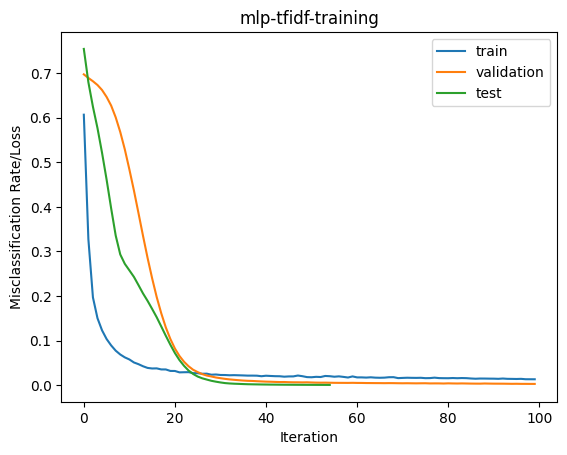

In [ ]:
#simple mlp neural networks
mlp_classifier1 = MLPClassifier(hidden_layer_sizes=(50,25,20,10,5),
                           max_iter=100,activation = 'relu',
                           solver='adam',random_state=100).fit(train_d2v_features[0:y_train_val.shape[0],:], y_train)

y_pred = mlp_classifier1.predict(all_d2v_features)
print(confusion_matrix(y_all,y_pred))
print(classification_report(y_all,y_pred))
print_results(y_all , y_pred , 'MLP_Basic1_alldata(d2v)))


y_pred = mlp_classifier1.predict(test_d2v_features)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print_results(y_test , y_pred , 'MLP_Basic1(d2v)')


mlp_classifier2 = MLPClassifier(hidden_layer_sizes=(50,25,20,10,5),
                           max_iter=100,activation = 'relu',
                           solver='adam',random_state=100).fit(X_train_val, y_train_val)

y_pred = mlp_classifier2.predict(X_all)
print(confusion_matrix(y_all,y_pred))
print(classification_report(y_all,y_pred))
print_results(y_all , y_pred , 'MLP_Basic_2_all_data')


y_pred = mlp_classifier2.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print_results(y_test , y_pred , 'MLP_Basic_2')

#Third MLP classifier
mlp_classifier3 = MLPClassifier(hidden_layer_sizes=(150,100,50),
                           max_iter=100,activation = 'relu',
                           solver='adam',random_state=100).fit(X_train_val, y_train_val)

y_pred = mlp_classifier3.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

mlp_classifier3.fit(X_train,y_train); plt.plot(mlp_classifier3.loss_curve_,label="train")
mlp_classifier3.fit(X_valid,y_valid); plt.plot(mlp_classifier3.loss_curve_,label="validation")
mlp_classifier3.fit(X_test,y_test); plt.plot(mlp_classifier3.loss_curve_,label="test")

plt.xlabel("Iteration")
plt.ylabel("Misclassification Rate/Loss");
plt.legend(loc='upper right')
plt.title('mlp-tfidf-training')
plt.show()

In [ ]:
#init cuda usage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)
print(device)


cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.layers.append(nn.Tanh())
        self.layers.append(nn.Dropout(0.2))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.2))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#build and train model
input_size = X_train_val.shape[1]  # Adjust this based on your input features
hidden_sizes = [500, 250, 100, 50]

# Instantiate the model_mlp
model_mlp = MLPModel(input_size, hidden_sizes)
model_mlp.to(device)

# Loss and optimizer
criterion = nn.BCELoss()  #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #nn.MSELoss() #nn.KLDivLoss() # nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

data_X = torch.Tensor(X_train_val).to(device)
data_y = torch.Tensor(y_train_val).view(-1, 1).to(device)

# Create DataLoader for the dataset
dataset = TensorDataset(data_X, data_y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
top_n      = 10 # top n better models
num_epochs = 250
losses     = [10000]* top_n
# Get the current date and time
current_datetime_str = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

model_mlp.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')
    # Save better models:
    cur_loss = total_loss
    for k in range(len(losses)):
        if cur_loss < losses[k]:
            losses[k] = cur_loss
            if k < top_n:
                model_file_name = f"mlp_model_best_{k:02d}_{current_datetime_str}.pth"
                torch.save(model_mlp.state_dict(), model_file_name)
                #print(losses)
                break


#save the last model_mlp
print(losses)
model_file_name = f"mlp_model_last_{current_datetime_str}.pth"
torch.save(model_mlp, model_file_name)

#------------------------------------------
# Lets get training accuracy
# Set the model_mlp to evaluation mode and evaluate it on train data:
model_mlp.eval()
with torch.no_grad():
  #Training accuracy
  predictions = model_mlp(torch.Tensor(X_train_val).to(device))
  predictions[predictions >= 0.5]  = 1
  predictions[predictions <  0.5]  = 0
  print_results(y_train_val , predictions.cpu(), 'MLP_torch_train, ' + current_options)

  # Test accuracy
  predictions = model_mlp(torch.Tensor(X_test).to(device))
  predictions[predictions >= 0.5]  = 1
  predictions[predictions <  0.5]  = 0
  print_results(y_test , predictions.cpu(), 'MLP_torch_test, ' + current_options)

#print the model
print(model_mlp)

**CNN Network for Classification**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Lambda
from torch.nn.functional import softmax , relu, tanh
from torch.nn.functional import sigmoid
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout_rate=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(num_filters * len(filter_sizes), 64)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, inputs):
        x = self.embedding(inputs).permute(0, 2, 1)  # Permute to (batch_size, embedding_dim, sequence_length)
        conv_outputs = [conv(x) for conv in self.conv_layers]
        pooled_outputs = [torch.max(conv_output, dim=2)[0] for conv_output in conv_outputs]
        concatenated = torch.cat(pooled_outputs, dim=1)
        concatenated = self.dropout(concatenated)
        output1      = self.fc1(concatenated)
        output1      = tanh(output1)
        output = self.fc(output1)
        return softmax(output, dim=1)



#deter mine maximum sequence length
max_seq_length = 64

#Preprocess data
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in all_df['sentence']:
    counter.update(tokenizer(line))
vocab = build_vocab_from_iterator([tokenizer(line) for line in all_df['sentence']], specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
x_data = []
y_data = label_encoder.fit_transform(all_df['label'])
for line in all_df['sentence']:
    seq_line = torch.tensor([vocab[token] for token in tokenizer(line)])
    if len(seq_line > max_seq_length ): #truncate longer sequences
      seq_line = seq_line[0:max_seq_length]
    x_data.append(seq_line)

# Pad sequences and convert to tensors
x_data = nn.utils.rnn.pad_sequence(x_data, batch_first=True).to(device)
y_data = torch.tensor(y_data).to(device)

# Split data into train/validation sets
x_data_train = x_data[0:len(y_train_val),:] ; y_data_train = y_data[0:len(y_train_val)]
x_data_val = x_data[len(y_train_val):,:] ; y_data_val = y_data[len(y_train_val):]

# Example: Instantiate the TextCNN model
embedding_dim = 100
num_filters = 32
filter_sizes = [3, 5, 7]
num_classes = 2
dropout_rate = 0.5

model_cnn = TextCNN(vocab_size=len(vocab),
                embedding_dim=embedding_dim,
                num_filters=num_filters,
                filter_sizes=filter_sizes,
                num_classes=num_classes,
                dropout_rate=dropout_rate).to(device)

#Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters())

# Example: Train the model
model_cnn.to(device)
batch_size = 64
epochs = 250
model_cnn.train()
for epoch in range(epochs):
    acc_loss = 0
    for i in range(0, len(x_data_train), batch_size):
        optimizer.zero_grad()
        batch_x, batch_y = x_data_train[i:i+batch_size,:], y_data_train[i:i+batch_size]
        outputs = model_cnn(batch_x)
        #print(outputs[:,1] , batch_y)
        loss = criterion(batch_y.float(), outputs[:,1]) +  criterion(torch.add(-batch_y.float(),1), outputs[:,0])

        loss.backward()
        optimizer.step()
        acc_loss += loss.item()

    #print accumumlated epoch loss
    print(f'Epoch {epoch+1}/{epochs}\tLoss: {acc_loss:.4f}')

# Example: Evaluate the model on validation data
model_cnn.eval()
with torch.no_grad():
    outputs = model_cnn(x_data_val)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_data_val).sum().item()
    accuracy = correct / len(y_data_val)
    print(f'Validation Accuracy: {accuracy:.4f}')
    print_results(y_data_val.cpu(),predicted.cpu() , f'Text CNN, {max_seq_length}')

**BiLSTM for Classification**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter


# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, dropout_rate):
        super(BiLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,dropout=dropout_rate, bidirectional=True, batch_first=True)

        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        embeds      = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        output      = self.fc(lstm_out[:,-1,:])
        return output

#Convert data to sequences of equal length

#determine maximum sequence length
max_seq_length = 64

#Preprocess data
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator([tokenizer(line) for line in all_df['sentence']], specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
x_data = []
y_data = label_encoder.fit_transform(all_df['label'])
for line in all_df['sentence']:
    seq_line = torch.tensor([vocab[token] for token in tokenizer(line)])
    if len(seq_line > max_seq_length ): #truncate longer sequences
      seq_line = seq_line[0:max_seq_length]
    x_data.append(seq_line)

# Pad sequences and convert to tensors
x_data = nn.utils.rnn.pad_sequence(x_data, batch_first=True).to(device)
y_data = torch.tensor(y_data).to(device)

# Split data into train/validation sets
x_data_train = x_data[0:len(y_train_val),:]; y_data_train  = y_data[0:len(y_train_val)]
x_data_val   = x_data[len(y_train_val):,:];  y_data_val    = y_data[len(y_train_val):]

# Define model parameters
input_dim = x_data.shape[1]
embedding_dim = 100
hidden_dim = 50
output_dim = 2  # Assuming binary classification
dropout = 0.5



# Initialize model, loss function, and optimizer
model_lstm = BiLSTM(vocab_size = len(vocab),
               embedding_dim=embedding_dim,
               hidden_dim=hidden_dim,
               output_dim=2,
               dropout_rate=dropout)

model_lstm.to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters())

# Example: Train the model
batch_size = 32
epochs = 100
model_lstm.train()
for epoch in range(epochs):
    acc_loss = 0
    for i in range(0, len(x_data_train), batch_size):
        optimizer.zero_grad()
        batch_x, batch_y = x_data_train[i:i+batch_size,:], y_data_train[i:i+batch_size]
        outputs = model_lstm(batch_x)
        loss = criterion(batch_y.float(), outputs[:,1]) +  criterion(torch.add(-batch_y.float(),1), outputs[:,0])
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
        #print(loss.item())

    #print accumumlated epoch loss
    print(f'Epoch {epoch+1}/{epochs}\tLoss: {acc_loss:.4f}')

# Example: Evaluate the model on validation data
model_lstm.eval()
with torch.no_grad():
    outputs = model_lstm(x_data_val)

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_data_val).sum().item()
    accuracy = correct / len(y_data_val)
    print(f'Validation Accuracy: {accuracy:.4f}')
    print_results(y_data_val.cpu(),predicted.cpu() , f'LSTM-2layers, {max_seq_length}' )
    print_per_class_results(y_data_val.cpu(),predicted.cpu() )

Validation Accuracy: 0.8932
LSTM-2layers, 64,	Accuracy=0.89,	C0: Pr=0.97, Re=0.91, F1=0.94,	C1: Pr=0.49, Re=0.76, F1=0.60
something went wrong cannot insert LSTM-2layers, 64, already exists
,	 class=0	Accuracy=0.89,	 Precision=0.97,	Recall=0.91	F1-score=0.94
,	 class=1	Accuracy=0.89,	 Precision=0.49,	Recall=0.76	F1-score=0.60


**Network Visualization**

In [ ]:
!pip install torchviz

In [69]:
from torchviz import make_dot
make_dot(model_lstm(x_data_train), params=dict(list(model_lstm.named_parameters()))).render("./graphs/graph_lstm_torchviz", format="png")


'graphs\\graph_lstm_torchviz.png'

In [78]:
#!mkdir ./graphs
x_temp_mlp =torch.Tensor(X_train_val[0:10,:]).to(device)
make_dot(model_mlp(x_temp_mlp), params=dict(list(model_lstm.named_parameters()))).render("./graphs/graph_model_architecture_mlp", format="png")
make_dot(model_cnn(batch_x), params=dict(list(model_cnn.named_parameters()))).render("./graphs/graph_model_architecture_cnn", format="png")

#create_graph(model_cnn , './graphs/graph_model_architecture_cnn' , 'png')
#create_graph(model_lstm , './graphs/graph_model_architecture_lstm' , 'png')


'graphs\\graph_model_architecture_cnn.png'

In [ ]:
!pip install graphviz

In [ ]:
import torch
from graphviz import Digraph  # Install graphviz with pip install graphviz

# Define a function to create a node for a layer
def create_node(layer_name, layer_type):
    return f'{layer_name} ({layer_type})'

def create_graph(model, fname , fmt="png"):
  # Create a directed graph object
  dot = Digraph()
  # Iterate through your model layers and add nodes and edges
  in_layer = None  # Keep track of the previous layer
  for i, layer in enumerate(model.modules()):
      if isinstance(layer, torch.nn.Module):
          layer_name = f'Layer {i+1}'
          layer_type = str(layer).split('(')[0]  # Extract layer type

          dot.node(layer_name, create_node(layer_name, layer_type))

          if in_layer is not None:
              dot.edge(in_layer, layer_name)  # Add edge from previous layer to current

          in_layer = layer_name

  # Render the graph to a file
  dot.render(filename=fname+"."+fmt, format=fmt)

#plot networks
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [ ]:
!mkdir ./graphs
create_graph(model_mlp , './graphs/graph_model_architecture_mlp' , 'png')
create_graph(model_cnn , './graphs/graph_model_architecture_cnn' , 'png')
create_graph(model_lstm , './graphs/graph_model_architecture_lstm' , 'png')


The syntax of the command is incorrect.


In [ ]:
print(model_cnn)

TextCNN(
  (embedding): Embedding(9447, 100)
  (conv_layers): ModuleList(
    (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 128, kernel_size=(5,), stride=(1,))
    (2): Conv1d(100, 128, kernel_size=(7,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=384, out_features=2, bias=True)
)


**Mixture of Experts**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Instantiate base classifiers
rf_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()
lr_classifier = LogisticRegression()
mlp_classifier = MLPClassifier()

# Train base classifiers on your imbalanced dataset
rf_classifier.fit(X_train_val, y_train_val)
gb_classifier.fit(X_train_val, y_train_val)
lr_classifier.fit(X_train_val, y_train_val)
mlp_classifier.fit(X_train_val, y_train_val)

# Make predictions on the test set
rf_preds = rf_classifier.predict(X_test)
gb_preds = gb_classifier.predict(X_test)
lr_preds = lr_classifier.predict(X_test)
mlp_preds = mlp_classifier.predict(X_test)

# Combine predictions using weighted voting
ensemble_preds = (0.25 * rf_preds + 0.25 * gb_preds + 0.25 * lr_preds + 0.25 * mlp_preds)
y_pred = np.zeros(y_test.shape)
y_pred[ensemble_preds >= 0.5] =1
# Evaluate the ensemble
print(classification_report(y_test, y_pred))
print_results(y_test, y_pred, 'MoE, Eq. Weight, ' + current_options )


# Make predictions on the training set
y_preds_rf  = rf_classifier.predict(X_train_val).reshape(-1,1)
y_preds_gb  = gb_classifier.predict(X_train_val).reshape(-1,1)
y_preds_lr  = lr_classifier.predict(X_train_val).reshape(-1,1)
y_preds_mlp = mlp_classifier.predict(X_train_val).reshape(-1,1)
y_pred_train_val = np.concatenate((y_preds_rf,y_preds_gb, y_preds_lr, y_preds_mlp ), axis=1)

# Instantiate base classifiers
rf_combiner = RandomForestClassifier()
gb_combiner = GradientBoostingClassifier()
lr_combiner = LogisticRegression()
mlp_combiner = MLPClassifier()

rf_combiner.fit(y_pred_train_val, y_train_val)
gb_combiner.fit(y_pred_train_val, y_train_val)
lr_combiner.fit(y_pred_train_val, y_train_val)
mlp_combiner.fit(y_pred_train_val, y_train_val)

# Make predictions on the test set
y_pred_test_rf  = rf_classifier.predict(X_test).reshape(-1,1)
y_pred_test_gb  = gb_classifier.predict(X_test).reshape(-1,1)
y_pred_test_lr  = lr_classifier.predict(X_test).reshape(-1,1)
y_pred_test_mlp = mlp_classifier.predict(X_test).reshape(-1,1)
y_pred_test = np.concatenate((y_pred_test_rf, y_pred_test_gb, y_pred_test_lr, y_pred_test_mlp ), axis=1)

rfc_preds = rf_combiner.predict(y_pred_test)
gbc_preds = gb_combiner.predict(y_pred_test)
lrc_preds = lr_combiner.predict(y_pred_test)
mlpc_preds = mlp_combiner.predict(y_pred_test)

ensemblec_preds = (0.25 * rfc_preds + 0.25 * gbc_preds + 0.25 * lrc_preds + 0.25 * mlpc_preds)

# Evaluate the ensemble
print_results(y_test, prob2label(rfc_preds),  'MoE, rf-cmb, ' + current_options )
print_results(y_test, prob2label(gbc_preds),  'MoE, gb-cmb, ' + current_options )
print_results(y_test, prob2label(lrc_preds),  'MoE, lr-cmb, ' + current_options )
print_results(y_test, prob2label(mlpc_preds), 'MoE, mlpc-cmb, ' + current_options )
print_results(y_test, prob2label(ensemblec_preds), 'MoE, all-cmb, ' + current_options )



In [ ]:
print(classification_report(y_test,prob2label( mlpc_preds)))

**Balanced Classification**

This experiments trains an ensemble of random forests on the balanced subsets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Separate instances for class 1
class_1_instances = X_train_val[y_train_val == 1,:]
class_0_instances = X_train_val[y_train_val == 0,:]
num_classifiers = 101
classifiers = []
number_of_samples = class_1_instances.shape[0]
# Build an ensemble of classifiers (Random Forests in this example)

for ks in range(1,num_classifiers+1):
  # Randomly sample 2000 instances from class 0
  indices = np.random.choice(class_0_instances.shape[0], number_of_samples, replace=True)
  sampled_class_0_instances = class_0_instances[indices,:]

  # Combine instances for class 1 and sampled instances from class 0
  balanced_X = np.concatenate([class_1_instances, sampled_class_0_instances])
  balanced_y = np.concatenate([np.ones(class_1_instances.shape[0]), np.zeros(sampled_class_0_instances.shape[0])])

  #classifier = RandomForestClassifier(n_estimators=101, random_state=100)
  #classifier = sklearn.linear_model.LogisticRegression(random_state=42)
  classifier = MLPClassifier(random_state=42)

  classifier.fit(balanced_X, balanced_y)
  classifiers.append(classifier)
  y_pred = classifier.predict(X_test)
  print_results(y_test , y_pred,  f'ensemble{ks} ' + current_options)

# Make predictions on the test set using each classifier
predictions = [classifier.predict(X_test) for classifier in classifiers]

# Take a majority vote to get the final ensemble prediction
ensemble_predictions = np.mean(predictions, axis=0) > 0.5

# Evaluate the ensemble performance
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy}')
print_results(y_test , ensemble_predictions,  'ensemble_total ' + current_options)


**Word2vec Model**

In this set of experiments we build and test several well-known
word2vec and doc2vec models

In [200]:

#basic functions
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

#Get embedding of a document as the mean of embeddings of its words
def get_doc2vec(model ,doc ):
  tokens = doc.lower().split()
  vec = np.zeros(model.vector_size)
  num_tokens = 0
  for token in tokens:
    try:
      vec += model.get_vector(token)
      num_tokens += 1
    except:
      token = 'unk' #print(f"{token} not found in vocab")

  if num_tokens > 0:
    vec /= num_tokens
  return vec.reshape(1,-1)

#Generate document vectors for all of the sentences:
def get_corpus_embeddings(model , documents):
  X = get_doc2vec(model, documents[0] )
  for i in range(1,len(documents)):
    X = np.append(X, get_doc2vec(model, documents[i]).reshape(1,-1), axis=0)

  return X


In [201]:

#gensim doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(all_df['sentence'].tolist())]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=100, dbow_words =1, epochs=100)

#Persist a model to disk:
fname = get_tmpfile("gensim_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

#Generate document vectors for all of the sentences:
X_d2v = get_corpus_embeddings (model.wv, all_df['sentence'].tolist())

test_basic_models(X_d2v[:y_train_val.shape[0],:], y_train_val,
                  X_d2v[y_train_val.shape[0]:,:], y_test, 'gensim_doc2vec, ')


basic K-Nearest Neighbors, gensim_doc2vec, ,	Accuracy=0.88,	C0: Pr=0.95, Re=0.92, F1=0.93,	C1: Pr=0.45, Re=0.56, F1=0.50
basic Linear Discrimination Analysis, gensim_doc2vec, ,	Accuracy=0.89,	C0: Pr=0.94, Re=0.94, F1=0.94,	C1: Pr=0.47, Re=0.45, F1=0.46


c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


basic Logistic Regression, gensim_doc2vec, ,	Accuracy=0.89,	C0: Pr=0.93, Re=0.94, F1=0.94,	C1: Pr=0.47, Re=0.44, F1=0.46
basic Support Vector Machine-L, gensim_doc2vec, ,	Accuracy=0.90,	C0: Pr=0.94, Re=0.94, F1=0.94,	C1: Pr=0.50, Re=0.49, F1=0.50
basic Support Vector Machine-R, gensim_doc2vec, ,	Accuracy=0.91,	C0: Pr=0.95, Re=0.96, F1=0.95,	C1: Pr=0.60, Re=0.54, F1=0.57
basic Support Vector Machine-S, gensim_doc2vec, ,	Accuracy=0.76,	C0: Pr=0.91, Re=0.81, F1=0.86,	C1: Pr=0.15, Re=0.30, F1=0.20
basic Support Vector Machine-WL, gensim_doc2vec, ,	Accuracy=0.63,	C0: Pr=0.98, Re=0.60, F1=0.75,	C1: Pr=0.21, Re=0.90, F1=0.34
basic Support Vector Machine-WR, gensim_doc2vec, ,	Accuracy=0.74,	C0: Pr=0.99, Re=0.71, F1=0.83,	C1: Pr=0.28, Re=0.94, F1=0.43
basic Support Vector Machine-WS, gensim_doc2vec, ,	Accuracy=0.50,	C0: Pr=0.95, Re=0.47, F1=0.63,	C1: Pr=0.15, Re=0.80, F1=0.25
basic Decision Tree classifier, gensim_doc2vec, ,	Accuracy=0.78,	C0: Pr=0.93, Re=0.82, F1=0.87,	C1: Pr=0.24, Re=0.49, F1

In [202]:
#gensim FastText
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

documents = all_df['sentence'].tolist()
docs=[]
for doc in documents:
  #print(doc.split())
  docs += [doc.split()]

model_fasttext = FastText(vector_size=40, window=3, min_count=1, sentences=docs, epochs=100)

fname = get_tmpfile("suggestion_fasttext.model")
model_fasttext.save(fname)
model_fasttext = FastText.load(fname)

#Generate document vectors for all of the sentences:
X_ft = get_corpus_embeddings (model_fasttext.wv, all_df['sentence'].tolist())

test_basic_models(X_ft[:y_train_val.shape[0],:], y_train_val,
                  X_ft[y_train_val.shape[0]:,:], y_test, 'gensim-fasttext-words')


basic K-Nearest Neighbors, gensim-fasttext-words,	Accuracy=0.87,	C0: Pr=0.94, Re=0.91, F1=0.92,	C1: Pr=0.39, Re=0.49, F1=0.43
basic Linear Discrimination Analysis, gensim-fasttext-words,	Accuracy=0.88,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.39, Re=0.33, F1=0.36
basic Logistic Regression, gensim-fasttext-words,	Accuracy=0.88,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.40, Re=0.33, F1=0.36
basic Support Vector Machine-L, gensim-fasttext-words,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.94,	C1: Pr=0.41, Re=0.30, F1=0.35
basic Support Vector Machine-R, gensim-fasttext-words,	Accuracy=0.90,	C0: Pr=0.94, Re=0.96, F1=0.95,	C1: Pr=0.54, Re=0.45, F1=0.49
basic Support Vector Machine-S, gensim-fasttext-words,	Accuracy=0.77,	C0: Pr=0.92, Re=0.81, F1=0.86,	C1: Pr=0.20, Re=0.39, F1=0.26
basic Support Vector Machine-WL, gensim-fasttext-words,	Accuracy=0.48,	C0: Pr=0.98, Re=0.42, F1=0.59,	C1: Pr=0.16, Re=0.94, F1=0.27
basic Support Vector Machine-WR, gensim-fasttext-words,	Accuracy=0.62,	C0: Pr=0.99, Re

In [206]:
#Test pretrained word2vec models:
import gensim.downloader
#models =['fasttext-wiki-news-subwords-300',
models  =['conceptnet-numberbatch-17-06-300',
         'word2vec-ruscorpora-300',
         'word2vec-google-news-300',
         'glove-wiki-gigaword-50',
         'glove-wiki-gigaword-100',
         'glove-wiki-gigaword-200',
         'glove-wiki-gigaword-300',
         'glove-twitter-25',
         'glove-twitter-50',
         'glove-twitter-100',
         'glove-twitter-200',
         '__testing_word2vec-matrix-synopsis',
         ]

#Play with pretrained word2vec embeddings
for model_name in models:
  print (model_name)
  model_fname = model_name + ".model"
  model_pretrained = gensim.downloader.load(model_name)

  #Generate document vectors for all of the sentences:
  X_gl = get_corpus_embeddings (model_pretrained, all_df['sentence'].tolist())
  try:
    test_basic_models(X_gl[:y_train_val.shape[0],:], y_train_val,
                    X_gl[y_train_val.shape[0]:,:], y_test, model_name)
  except Exception as E:
    print (f'Cannot eval word2vec {model_name}. Description {E}')



conceptnet-numberbatch-17-06-300


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


basic K-Nearest Neighbors, conceptnet-numberbatch-17-06-300,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
something went wrong cannot insert basic K-Nearest Neighbors, conceptnet-numberbatch-17-06-300, already exists
Cannot eval word2vec conceptnet-numberbatch-17-06-300. Description Internal work array size computation failed: -10
word2vec-ruscorpora-300


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


basic K-Nearest Neighbors, word2vec-ruscorpora-300,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
Cannot eval word2vec word2vec-ruscorpora-300. Description Internal work array size computation failed: -10
word2vec-google-news-300
basic K-Nearest Neighbors, word2vec-google-news-300,	Accuracy=0.85,	C0: Pr=0.93, Re=0.90, F1=0.92,	C1: Pr=0.32, Re=0.38, F1=0.35
basic Linear Discrimination Analysis, word2vec-google-news-300,	Accuracy=0.87,	C0: Pr=0.93, Re=0.93, F1=0.93,	C1: Pr=0.39, Re=0.37, F1=0.38
basic Logistic Regression, word2vec-google-news-300,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.40, Re=0.31, F1=0.35
basic Support Vector Machine-L, word2vec-google-news-300,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.41, Re=0.32, F1=0.36
basic Support Vector Machine-R, word2vec-google-news-300,	Accuracy=0.89,	C0: Pr=0.94, Re=0.94, F1=0.94,	C1: Pr=0.49, Re=0.53, F1=0.51
basic Support Vector Machine-S, word2vec-google-news-300,	Accuracy=0.77,	C

c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


basic Logistic Regression, glove-wiki-gigaword-50,	Accuracy=0.86,	C0: Pr=0.91, Re=0.94, F1=0.92,	C1: Pr=0.26, Re=0.18, F1=0.22


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


basic Support Vector Machine-L, glove-wiki-gigaword-50,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
basic Support Vector Machine-R, glove-wiki-gigaword-50,	Accuracy=0.89,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
basic Support Vector Machine-S, glove-wiki-gigaword-50,	Accuracy=0.72,	C0: Pr=0.90, Re=0.78, F1=0.83,	C1: Pr=0.12, Re=0.25, F1=0.16


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


basic Support Vector Machine-WL, glove-wiki-gigaword-50,	Accuracy=0.10,	C0: Pr=0.00, Re=0.00, F1=0.00,	C1: Pr=0.10, Re=1.00, F1=0.19
basic Support Vector Machine-WR, glove-wiki-gigaword-50,	Accuracy=0.22,	C0: Pr=1.00, Re=0.13, F1=0.23,	C1: Pr=0.12, Re=1.00, F1=0.21
basic Support Vector Machine-WS, glove-wiki-gigaword-50,	Accuracy=0.38,	C0: Pr=0.95, Re=0.32, F1=0.48,	C1: Pr=0.13, Re=0.86, F1=0.22
basic Decision Tree classifier, glove-wiki-gigaword-50,	Accuracy=0.72,	C0: Pr=0.93, Re=0.74, F1=0.82,	C1: Pr=0.18, Re=0.49, F1=0.27
glove-wiki-gigaword-100
basic K-Nearest Neighbors, glove-wiki-gigaword-100,	Accuracy=0.85,	C0: Pr=0.92, Re=0.91, F1=0.91,	C1: Pr=0.29, Re=0.32, F1=0.31
basic Linear Discrimination Analysis, glove-wiki-gigaword-100,	Accuracy=0.88,	C0: Pr=0.91, Re=0.95, F1=0.93,	C1: Pr=0.35, Re=0.23, F1=0.28


c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


basic Logistic Regression, glove-wiki-gigaword-100,	Accuracy=0.87,	C0: Pr=0.91, Re=0.94, F1=0.93,	C1: Pr=0.33, Re=0.24, F1=0.28
basic Support Vector Machine-L, glove-wiki-gigaword-100,	Accuracy=0.89,	C0: Pr=0.91, Re=0.97, F1=0.94,	C1: Pr=0.39, Re=0.17, F1=0.24
basic Support Vector Machine-R, glove-wiki-gigaword-100,	Accuracy=0.89,	C0: Pr=0.91, Re=0.98, F1=0.94,	C1: Pr=0.48, Re=0.17, F1=0.25
basic Support Vector Machine-S, glove-wiki-gigaword-100,	Accuracy=0.73,	C0: Pr=0.90, Re=0.79, F1=0.84,	C1: Pr=0.13, Re=0.28, F1=0.18
basic Support Vector Machine-WL, glove-wiki-gigaword-100,	Accuracy=0.36,	C0: Pr=1.00, Re=0.29, F1=0.45,	C1: Pr=0.14, Re=0.99, F1=0.24
basic Support Vector Machine-WR, glove-wiki-gigaword-100,	Accuracy=0.40,	C0: Pr=1.00, Re=0.33, F1=0.49,	C1: Pr=0.15, Re=0.99, F1=0.26
basic Support Vector Machine-WS, glove-wiki-gigaword-100,	Accuracy=0.39,	C0: Pr=0.94, Re=0.34, F1=0.50,	C1: Pr=0.13, Re=0.83, F1=0.22
basic Decision Tree classifier, glove-wiki-gigaword-100,	Accuracy=0.75,

c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


basic Logistic Regression, glove-wiki-gigaword-200,	Accuracy=0.87,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.34, Re=0.26, F1=0.30
basic Support Vector Machine-L, glove-wiki-gigaword-200,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.39, Re=0.26, F1=0.32
basic Support Vector Machine-R, glove-wiki-gigaword-200,	Accuracy=0.89,	C0: Pr=0.91, Re=0.97, F1=0.94,	C1: Pr=0.42, Re=0.22, F1=0.29
basic Support Vector Machine-S, glove-wiki-gigaword-200,	Accuracy=0.75,	C0: Pr=0.91, Re=0.80, F1=0.85,	C1: Pr=0.15, Re=0.31, F1=0.21
basic Support Vector Machine-WL, glove-wiki-gigaword-200,	Accuracy=0.43,	C0: Pr=0.99, Re=0.37, F1=0.54,	C1: Pr=0.15, Re=0.98, F1=0.27
basic Support Vector Machine-WR, glove-wiki-gigaword-200,	Accuracy=0.48,	C0: Pr=1.00, Re=0.42, F1=0.59,	C1: Pr=0.17, Re=0.99, F1=0.28
basic Support Vector Machine-WS, glove-wiki-gigaword-200,	Accuracy=0.43,	C0: Pr=0.96, Re=0.38, F1=0.54,	C1: Pr=0.14, Re=0.85, F1=0.24
basic Decision Tree classifier, glove-wiki-gigaword-200,	Accuracy=0.75,

c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Logistic Regression, glove-wiki-gigaword-300,	Accuracy=0.87,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.37, Re=0.32, F1=0.34
basic Support Vector Machine-L, glove-wiki-gigaword-300,	Accuracy=0.88,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.38, Re=0.31, F1=0.34


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-R, glove-wiki-gigaword-300,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.39, Re=0.28, F1=0.32


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-S, glove-wiki-gigaword-300,	Accuracy=0.76,	C0: Pr=0.91, Re=0.81, F1=0.86,	C1: Pr=0.17, Re=0.33, F1=0.22


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WL, glove-wiki-gigaword-300,	Accuracy=0.51,	C0: Pr=0.99, Re=0.46, F1=0.63,	C1: Pr=0.17, Re=0.95, F1=0.29


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WR, glove-wiki-gigaword-300,	Accuracy=0.57,	C0: Pr=0.99, Re=0.53, F1=0.69,	C1: Pr=0.19, Re=0.97, F1=0.32


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WS, glove-wiki-gigaword-300,	Accuracy=0.43,	C0: Pr=0.94, Re=0.38, F1=0.55,	C1: Pr=0.13, Re=0.80, F1=0.23


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Decision Tree classifier, glove-wiki-gigaword-300,	Accuracy=0.74,	C0: Pr=0.93, Re=0.76, F1=0.84,	C1: Pr=0.21, Re=0.54, F1=0.30
glove-twitter-25


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic K-Nearest Neighbors, glove-twitter-25,	Accuracy=0.85,	C0: Pr=0.92, Re=0.91, F1=0.92,	C1: Pr=0.31, Re=0.33, F1=0.32
basic Linear Discrimination Analysis, glove-twitter-25,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.37, Re=0.26, F1=0.31
basic Logistic Regression, glove-twitter-25,	Accuracy=0.87,	C0: Pr=0.92, Re=0.94, F1=0.93,	C1: Pr=0.35, Re=0.28, F1=0.31


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

basic Support Vector Machine-L, glove-twitter-25,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-R, glove-twitter-25,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
basic Support Vector Machine-S, glove-twitter-25,	Accuracy=0.73,	C0: Pr=0.90, Re=0.79, F1=0.84,	C1: Pr=0.13, Re=0.26, F1=0.17


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

basic Support Vector Machine-WL, glove-twitter-25,	Accuracy=0.10,	C0: Pr=0.00, Re=0.00, F1=0.00,	C1: Pr=0.10, Re=1.00, F1=0.19
basic Support Vector Machine-WR, glove-twitter-25,	Accuracy=0.20,	C0: Pr=1.00, Re=0.11, F1=0.20,	C1: Pr=0.12, Re=1.00, F1=0.21


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WS, glove-twitter-25,	Accuracy=0.34,	C0: Pr=0.94, Re=0.28, F1=0.44,	C1: Pr=0.12, Re=0.84, F1=0.21


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Decision Tree classifier, glove-twitter-25,	Accuracy=0.77,	C0: Pr=0.93, Re=0.80, F1=0.86,	C1: Pr=0.22, Re=0.47, F1=0.30
glove-twitter-50


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic K-Nearest Neighbors, glove-twitter-50,	Accuracy=0.85,	C0: Pr=0.93, Re=0.91, F1=0.92,	C1: Pr=0.33, Re=0.39, F1=0.36
basic Linear Discrimination Analysis, glove-twitter-50,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.37, Re=0.26, F1=0.31


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

basic Logistic Regression, glove-twitter-50,	Accuracy=0.88,	C0: Pr=0.92, Re=0.95, F1=0.93,	C1: Pr=0.39, Re=0.28, F1=0.32


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-L, glove-twitter-50,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.50, Re=0.01, F1=0.02


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-R, glove-twitter-50,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.50, Re=0.03, F1=0.06


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-S, glove-twitter-50,	Accuracy=0.74,	C0: Pr=0.90, Re=0.80, F1=0.85,	C1: Pr=0.13, Re=0.25, F1=0.17


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WL, glove-twitter-50,	Accuracy=0.20,	C0: Pr=1.00, Re=0.10, F1=0.19,	C1: Pr=0.12, Re=1.00, F1=0.21


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WR, glove-twitter-50,	Accuracy=0.29,	C0: Pr=1.00, Re=0.21, F1=0.35,	C1: Pr=0.13, Re=1.00, F1=0.23


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WS, glove-twitter-50,	Accuracy=0.37,	C0: Pr=0.95, Re=0.31, F1=0.47,	C1: Pr=0.13, Re=0.86, F1=0.22


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Decision Tree classifier, glove-twitter-50,	Accuracy=0.74,	C0: Pr=0.93, Re=0.77, F1=0.84,	C1: Pr=0.21, Re=0.51, F1=0.29
glove-twitter-100


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic K-Nearest Neighbors, glove-twitter-100,	Accuracy=0.85,	C0: Pr=0.92, Re=0.91, F1=0.92,	C1: Pr=0.31, Re=0.34, F1=0.32
basic Linear Discrimination Analysis, glove-twitter-100,	Accuracy=0.89,	C0: Pr=0.93, Re=0.95, F1=0.94,	C1: Pr=0.46, Re=0.36, F1=0.40


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

basic Logistic Regression, glove-twitter-100,	Accuracy=0.89,	C0: Pr=0.93, Re=0.95, F1=0.94,	C1: Pr=0.45, Re=0.37, F1=0.41
basic Support Vector Machine-L, glove-twitter-100,	Accuracy=0.89,	C0: Pr=0.92, Re=0.97, F1=0.94,	C1: Pr=0.46, Re=0.24, F1=0.32


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-R, glove-twitter-100,	Accuracy=0.90,	C0: Pr=0.92, Re=0.97, F1=0.94,	C1: Pr=0.52, Re=0.25, F1=0.34


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-S, glove-twitter-100,	Accuracy=0.75,	C0: Pr=0.90, Re=0.80, F1=0.85,	C1: Pr=0.14, Re=0.28, F1=0.19


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WL, glove-twitter-100,	Accuracy=0.41,	C0: Pr=0.99, Re=0.35, F1=0.52,	C1: Pr=0.15, Re=0.97, F1=0.26


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WR, glove-twitter-100,	Accuracy=0.44,	C0: Pr=1.00, Re=0.38, F1=0.55,	C1: Pr=0.16, Re=0.99, F1=0.27


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WS, glove-twitter-100,	Accuracy=0.37,	C0: Pr=0.95, Re=0.32, F1=0.47,	C1: Pr=0.13, Re=0.86, F1=0.22


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Decision Tree classifier, glove-twitter-100,	Accuracy=0.76,	C0: Pr=0.93, Re=0.79, F1=0.85,	C1: Pr=0.22, Re=0.51, F1=0.31
glove-twitter-200


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic K-Nearest Neighbors, glove-twitter-200,	Accuracy=0.86,	C0: Pr=0.93, Re=0.91, F1=0.92,	C1: Pr=0.36, Re=0.44, F1=0.39


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Linear Discrimination Analysis, glove-twitter-200,	Accuracy=0.88,	C0: Pr=0.93, Re=0.95, F1=0.94,	C1: Pr=0.42, Re=0.34, F1=0.38


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)
c:\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarni

basic Logistic Regression, glove-twitter-200,	Accuracy=0.88,	C0: Pr=0.93, Re=0.94, F1=0.94,	C1: Pr=0.43, Re=0.37, F1=0.40
basic Support Vector Machine-L, glove-twitter-200,	Accuracy=0.88,	C0: Pr=0.93, Re=0.94, F1=0.93,	C1: Pr=0.41, Re=0.36, F1=0.38


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-R, glove-twitter-200,	Accuracy=0.90,	C0: Pr=0.92, Re=0.97, F1=0.95,	C1: Pr=0.54, Re=0.31, F1=0.39


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-S, glove-twitter-200,	Accuracy=0.75,	C0: Pr=0.90, Re=0.80, F1=0.85,	C1: Pr=0.14, Re=0.28, F1=0.19


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WL, glove-twitter-200,	Accuracy=0.52,	C0: Pr=0.99, Re=0.47, F1=0.64,	C1: Pr=0.17, Re=0.94, F1=0.29


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WR, glove-twitter-200,	Accuracy=0.52,	C0: Pr=0.99, Re=0.47, F1=0.64,	C1: Pr=0.18, Re=0.97, F1=0.30


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Support Vector Machine-WS, glove-twitter-200,	Accuracy=0.40,	C0: Pr=0.96, Re=0.35, F1=0.51,	C1: Pr=0.13, Re=0.87, F1=0.23


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic Decision Tree classifier, glove-twitter-200,	Accuracy=0.76,	C0: Pr=0.93, Re=0.79, F1=0.85,	C1: Pr=0.21, Re=0.48, F1=0.29
__testing_word2vec-matrix-synopsis


C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


basic K-Nearest Neighbors, __testing_word2vec-matrix-synopsis,	Accuracy=0.90,	C0: Pr=0.90, Re=1.00, F1=0.94,	C1: Pr=0.00, Re=0.00, F1=0.00
Cannot eval word2vec __testing_word2vec-matrix-synopsis. Description Internal work array size computation failed: -10


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mmr\AppData\Local\Temp\ipykernel_18236\3213305879.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df.insert(len(results_df.columns),description, y_pred)


**Longest Common Subsequence**

In [ ]:
def longest_common_subsequence(str1, str2):
    words1 = str1.split()
    words2 = str2.split()

    m = len(words1)
    n = len(words2)

    # Initializing the dp table with zeros
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Building the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if words1[i - 1] == words2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Backtracking to find the longest common subsequence
    lcs_length = dp[m][n]
    lcs = []
    i = m
    j = n
    while i > 0 and j > 0:
        if words1[i - 1] == words2[j - 1]:
            lcs.append ( words1[i - 1])
            i -= 1
            j -= 1
            lcs_length -= 1
        elif dp[i - 1][j] > dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    lcs.reverse()
    return lcs , (len(lcs))/ (0.0001+m) # 0.0001 is denom is there to prevent div by 0
# Example usage:
str1        = "roses are red. violets are blue"
str2        = "the garden is full of roses and violets that are blue "
lcs12 , r12 = longest_common_subsequence(str1, str2)
print(f"Longest Common Subsequence:{r12}: {lcs12} ")


In [ ]:
import sys
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords_list(tokens):
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

def remove_stopwords_str(str):
  str = re.sub(r'[^A-Za-z0-9]+', ' ', str)
  str = re.sub(r'\W+', ' ', str)
  str = re.sub(r'\s+', ' ', str)

  tokens = str.split()
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return ' '.join(filtered_tokens)

#--------------------
#

do_lcs = True # switch this flag if you want to run lcs

if do_lcs:
  train = train_df['sentence'].tolist(); train  = [remove_stopwords_str(s) for s in train ]
  test  = test_df['sentence'].tolist();  test   = [remove_stopwords_str(s) for s in test ]
  valid = valid_df['sentence'].tolist(); valid  = [remove_stopwords_str(s) for s in valid ]

  X = train + valid ;   y = y_train_val
  num_train = len(X);   num_test  = len(test)

  with open('train_test_lcs03.txt', 'w') as f:
    for m in range(num_train):
      if y[m] == 1:
        for n in range(num_test):
          temp, r = longest_common_subsequence (X[m], test[n])
          if r >= 0.01:
            print(f"{m}\t{n}\t{y[m]}\t{y_test[n]}\t{r:0.02f}\t{len(temp)}\t{temp}",file=f)


In [ ]:
import numpy as np
from nltk.corpus import wordnet as wn

def wordnet_path_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    if not synsets1 or not synsets2:
        return 0
    else:
        max_similarity = 0
        for synset1 in synsets1:
            for synset2 in synsets2:
                path_similarity = synset1.path_similarity(synset2)
                if path_similarity is not None and path_similarity > max_similarity:
                    max_similarity = path_similarity
        return max_similarity

def dtw_distance(s1, s2, similarity_function=wordnet_path_similarity):
    len_s1, len_s2 = len(s1), len(s2)
    dtw_matrix = np.zeros((len_s1 + 1, len_s2 + 1))

    # Initialize the DTW matrix with infinity
    for i in range(len_s1 + 1):
        for j in range(len_s2 + 1):
            dtw_matrix[i, j] = float('inf')

    dtw_matrix[0, 0] = 0

    # Calculate DTW matrix
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 1 - similarity_function(s1[i - 1], s2[j - 1])  # Using WordNet similarity as cost
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])

    return dtw_matrix[len_s1, len_s2]

def dtw_distance_str(s1, s2):
  return dtw_distance(s1.split() , s2.split())

# Example lists of strings
list1 = ['cat', 'dog', 'fish']
list2 = ['cat', 'fish', 'bird']

# Calculate DTW similarity
dtw_distance_score = dtw_distance(list1, list2)

print("DTW Similarity:", dtw_distance_score)


In [ ]:
#--------------------
#

do_dtw = True # switch this flag if you want to run lcs

if do_dtw:
  train = train_df['sentence'].tolist(); train  = [remove_stopwords_str(s) for s in train ]
  test  = test_df['sentence'].tolist();  test   = [remove_stopwords_str(s) for s in test ]
  valid = valid_df['sentence'].tolist(); valid  = [remove_stopwords_str(s) for s in valid ]

  X = train + valid ;   y = y_train_val
  num_train = len(X);   num_test  = len(test)

  with open('train_test_dtw02.txt', 'w') as f2:
    for m in range(num_train):
      if y[m] == 1:
        s1 = X[m].split() ; n1 = len(s1)
        for n in range(num_test):
          s2 = test[n].split() ; n2 = len(s2)
          r = 1- (dtw_distance (s1, s2) /(n1+n2 + 0.00000001))
          #print(f"{m}\t{n}\t{y[m]}\t{y_test[n]}\t{r:0.02f}")
          print(f"{m}\t{n}\t{y[m]}\t{n1}\t{n2}\t{y_test[n]}\t{r:0.02f}",file=f2)
